In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
dest = '/content/drive/MyDrive/Python/Stock-Price-Predict/'
BaseDat = pd.read_csv(dest + 'Stock-Pred-2.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Convert Date column from just string to DateTime
BaseDat['Date'] = pd.to_datetime(BaseDat['Date'])
# Set the column 'Date' as index (skip if already done)
BaseDat = BaseDat.set_index('Date')
# Specify datetime frequency
BaseDat = BaseDat.asfreq('D')
# fill the new created dates with null values using forward fill method
BaseDat = BaseDat.fillna(method = 'ffill')
# drop obs with missing data
BaseDat = BaseDat.dropna()
print(BaseDat.columns)
print(BaseDat.head)

Index(['Aug_Price', 'Aug_Volume', 'Search', 'CleanTec_Price',
       'CleanTec_Volume'],
      dtype='object')
<bound method NDFrame.head of             Aug_Price  Aug_Volume  Search  CleanTec_Price  CleanTec_Volume
Date                                                                      
2020-12-13     9750.0     9645.87    37.0         1140.15         58187.16
2020-12-14    10420.0    14690.12    37.0         1154.83         95169.62
2020-12-15    10750.0     7696.10    37.0         1161.47         68235.26
2020-12-16    10310.0     5141.85    37.0         1159.07         72743.43
2020-12-17     9877.0     3465.11    37.0         1146.72        110550.04
...               ...         ...     ...             ...              ...
2021-11-28     5600.0     2225.50    13.0          999.96         51036.77
2021-11-29     5857.0     1874.89    13.0         1002.99         54832.81
2021-11-30     5962.0     1055.59    13.0          997.68         60455.08
2021-12-01     6400.0     9099.55 

basic plot of the stock price behaviour

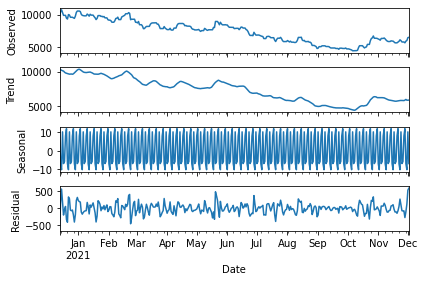

In [ ]:
decomposition = sm.tsa.seasonal_decompose(BaseDat['Aug_Price'], model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

Correlation matrix

In [ ]:
pd.DataFrame(BaseDat.corr()).to_excel(dest + 'CorrMatrix.xlsx')

In [ ]:
# this table will hold the testing metrics from the various models
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])

## Model - 1. forecasting using the AugWind price variable only

In [ ]:
BaseDat['Time'] = (BaseDat.index.year) * 10000 + (BaseDat.index.month) * 100 + BaseDat.index.day
Train = BaseDat[BaseDat.index<='11-1-2021']
Test = BaseDat[BaseDat.index>'11-1-2021']
x_train = Train[['Time']]
y_train = Train[['Aug_Price']]
x_test = Test[['Time']]
y_test = Test[['Aug_Price']]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
Reg = LinearRegression().fit(x_train, y_train)
forec_Mod1 = Reg.predict(x_test)
# Save relevant metrics
Compare_Table = Compare_Table.append({'Model': 'AugWind Price only',
                                      'MAE':mean_absolute_error(y_test, forec_Mod1),
                                      'MSE':mean_squared_error(y_test, forec_Mod1),
                                      'EVS':explained_variance_score(y_test, forec_Mod1),
                                      'COD':r2_score(y_test, forec_Mod1)}, ignore_index=True)

## Model- 2. forecasting with features (explanatory variables)

In [ ]:
x_train = Train.drop(columns=['Aug_Price'])
x_test = Test.drop(columns=['Aug_Price'])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
reg = LinearRegression().fit(x_train, y_train)
forec_Mod2 = reg.predict(x_test)
Compare_Table = Compare_Table.append({'Model': 'with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod2),
                                      'MSE':mean_squared_error(y_test, forec_Mod2),
                                      'EVS':explained_variance_score(y_test, forec_Mod2),
                                      'COD':r2_score(y_test, forec_Mod2)}, ignore_index=True)

In [ ]:
print(Compare_Table)

                Model          MAE           MSE       EVS        COD
0  AugWind Price only  1135.204179  1.352057e+06 -0.019582 -20.754113
1       with features  1200.327163  1.535234e+06 -0.519638 -23.701352


## Model - 3. ARIMA model using the SARIMAX without features

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1)).fit()
forec_Mod3 = ARMAmodel.predict(start = y_test.index[0], end = y_test.index[-1])
Compare_Table = Compare_Table.append({'Model': 'Sarimax without features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod3),
                                      'MSE':mean_squared_error(y_test, forec_Mod3),
                                      'EVS':explained_variance_score(y_test, forec_Mod3),
                                      'COD':r2_score(y_test, forec_Mod3)}, ignore_index=True)

## Model - 4. SARIMAX including features
note: arimax model include auto regressors of laged 'Aug_Price' so no need to keep the 'Time' variable

In [ ]:
x_train = Train.drop(columns=['Aug_Price','Time'])
x_test = Test.drop(columns=['Aug_Price','Time'])
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1), exog=x_train).fit()
forec_Mod4 = ARMAmodel.predict(start = y_test.index[0], end = y_test.index[-1], exog=x_test)
Compare_Table = Compare_Table.append({'Model': 'Sarimax with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod4),
                                      'MSE':mean_squared_error(y_test, forec_Mod4),
                                      'EVS':explained_variance_score(y_test, forec_Mod4),
                                      'COD':r2_score(y_test, forec_Mod4)}, ignore_index=True)

## Model 5. LSTM - PyTorch

### 5.a - rearange the data, drop irrelevnat variables

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)
y_train = mm.fit_transform(y_train)
y_test = mm.fit_transform(y_test)
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: (324, 4) (324, 1)
Test: (31, 4) (31, 1)


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
#- transform to tensors -#
x_train = Variable(torch.Tensor(x_train))
x_test = Variable(torch.Tensor(x_test))
y_train = Variable(torch.Tensor(y_train))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([324, 4]) torch.Size([324, 1])
Test: torch.Size([31, 4]) (31, 1)


In [ ]:
# reshaping to rows, timestamps, features
x_train = torch.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([324, 1, 4]) torch.Size([324, 1])
Test: torch.Size([31, 1, 4]) (31, 1)


### 5.b define the model

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

###5.c choose the model parameters

In [ ]:
num_epochs = 1000
learning_rate = 0.001
input_size = 4 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1]) #our lstm class
criterion = torch.nn.MSELoss()    # Criterion of minimization (mean-squared error)
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

### 5.d Training the model

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = criterion(outputs, y_train)
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.23671
Epoch: 100, loss: 0.03253
Epoch: 200, loss: 0.01012
Epoch: 300, loss: 0.00889
Epoch: 400, loss: 0.00814
Epoch: 500, loss: 0.00773
Epoch: 600, loss: 0.00750
Epoch: 700, loss: 0.00729
Epoch: 800, loss: 0.00697
Epoch: 900, loss: 0.00674


### 5.e prediction and test of the model

In [ ]:
train_predict = lstm1(x_test) #forward pass
forec_Mod5 = train_predict.data.numpy() #numpy conversion
forec_Mod5 = mm.inverse_transform(forec_Mod5) #reverse transformation
y_test = mm.inverse_transform(y_test) #reverse transformation of y_test for comparison

In [ ]:
Compare_Table = Compare_Table.append({'Model': 'LSTM - PyTorch',
                                      'MAE':mean_absolute_error(y_test, forec_Mod5),
                                      'MSE':mean_squared_error(y_test, forec_Mod5),
                                      'EVS':explained_variance_score(y_test, forec_Mod5),
                                      'COD':r2_score(y_test, forec_Mod5)}, ignore_index=True)

## Final Results

In [ ]:
print(Compare_Table)

                      Model          MAE           MSE       EVS        COD
0        AugWind Price only  1135.204179  1.352057e+06 -0.019582 -20.754113
1             with features  1200.327163  1.535234e+06 -0.519638 -23.701352
2  Sarimax without features   308.859599  1.220795e+05 -0.000878  -0.964215
3     Sarimax with features   290.511134  1.101475e+05 -0.133419  -0.772233
4            LSTM - PyTorch   267.266743  9.191728e+04 -0.255583  -0.478916


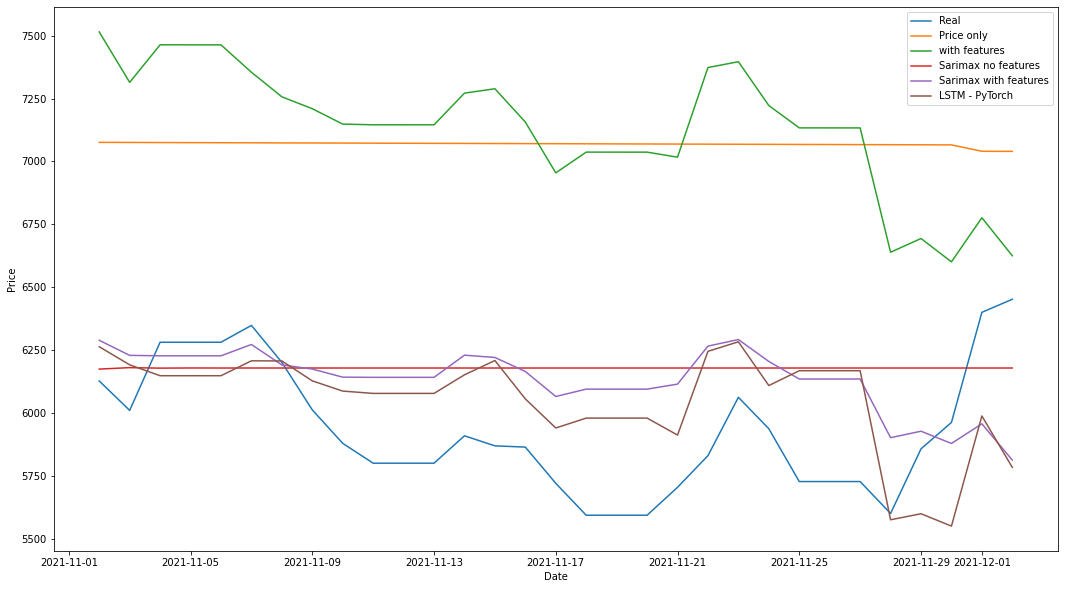

In [ ]:
x_axis = BaseDat[BaseDat.index>'11-1-2021']
x_axis = x_axis.index
plt.figure(figsize=(18, 10))
plt.plot(x_axis, y_test, label = 'Real')
plt.plot(x_axis, forec_Mod1, label = 'AugWind Price only')
plt.plot(x_axis, forec_Mod2, label = 'with features')
plt.plot(x_axis, forec_Mod3, label = 'Sarimax no features')
plt.plot(x_axis, forec_Mod4, label = 'Sarimax with features')
plt.plot(x_axis, forec_Mod5, label = 'LSTM - PyTorch')
plt.xlabel('Date'); plt.ylabel('Price');
plt.legend();